# Shared Response Modeling
[Contributions](#contributions)

What is reliable across different participants when performing the same task, for example watching a movie? In previous notebooks, inter-subject correlation and inter-subject functional correlation revealed similarity in patterns of brain activity across participants. We can exploit this similarity to find a lower-dimensional shared space that retains features of the data that are common across participants. The shared response model (SRM) aims to learn this shared feature space and how to map individual participant data into it ([Chen et al., 2015](https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model)). SRM can be used as a functional alignment technique: once fit, other data from the same participants can be transformed into the shared space with these mappings, to be used as input for other analyses.

In SRM, the brain data for each participant $i$ are represented as an $n$ voxel by $t$ time matrix $X_i$. A pre-specified number of features are used to learn a $k$ feature by $t$ time shared space $S$ and a participant-specific $n$ voxel by $k$ feature matrix $W_i$. This weight matrix, reflecting the loading of voxels onto features, is randomly initialized then fit over iterations to minimize the error in explaining participant data. At the same time, the time course of the features in the shared space is learned.

SRM can be summarized graphically as follows (from [Cohen et al., 2017](https://www.nature.com/articles/nn.4499)):![image](https://media.springernature.com/m685/nature-assets/neuro/journal/v20/n3/images/nn.4499-F4.jpg)

SRM requires that each participant be exposed to the same sequence of stimulus events. For this reason, continuous movies or stories are often used, although datasets (e.g., block-design localizers) where the trials are in the same order across participants have also been used with SRM. If counterbalancing was used between participants, it is technically possible to still perform SRM by rearranging the data, although mileage may vary. For best results, the epochs that are counterbalanced ought to be long (e.g., >30s). It is also important to note that SRM needs a lot of training data, up to 400 TRs or more for stable performance.

## Goal of this script
    1. Learn how to fit SRM.  
    2. Use SRM to match a movie time segment.  
    3. Use SRM to classify other datasets.  


## Table of Contents
[1. Setup](#setup)  
>[1.1 Dataset description](#data_description)  
>[1.2 Example: Shared Lasagne Making](#SRM_logic)  
>[1.3 Splitting data into training and test](#split)

[2. SRM training](#srm_training)  
>[2.1 Similarity of timepoints](#srm_timepoints)  
>[2.2 The weight matrix](#srm_weights)  
>[2.3 ISC and SRM](#srm_alignment)

[3. SRM testing](#srm_testing)  
[4. Signal reconstruction](#srm_reconstruction)  
[5. Time-segment matching](#time_seg)  
[6. Pieman analysis](#pieman)  
[7. Image class prediction](#image_pred)

#### Exercises
>[1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)   [9](#ex9)  [10](#ex10)  
>[Novel contribution](#novel)  

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 

import numpy as np
from scipy import stats
import scipy.spatial.distance as sp_distance
from sklearn.svm import NuSVC
import nibabel as nib

from brainiak.isc import isc
from brainiak.fcma.util import compute_correlation
import brainiak.funcalign.srm
from brainiak import image, io

import matplotlib.pyplot as plt

%autosave 5
%matplotlib inline

Autosaving every 5 seconds


## 1. Setup <a id="setup"></a>

### 1.1 Dataset description<a id="data_description"></a>

There are two datasets used in this notebook:

1. Raider dataset ([Haxby et al., 2011](https://doi.org/10.1016/j.neuron.2011.08.026)): We are using a pre-processed version of the data containing voxels from ventral temporal (VT) cortex in 10 subjects watching the movie, "Raiders of the Lost Ark". For these same participants and voxels, the dataset also includes eight runs where participants viewed images from seven categories. Each TR was 3s long and the movie was 2203 TRs long in total. Because the data have already been pre-processed and turned into a numpy file, we don't need to load them with nibabel tools.

2. Pieman dataset ([Simony et al., 2016](https://doi.org/10.1038/ncomms12141)): A full description of the dataset can be found in the ISC notebook. It includes 18 subjects who listened to a real-life story lasting seven minutes (intact condition). Subjects also listened to two scrambled versions of the story, generated by dividing the story into segments of different timescales (paragraphs and words, respectively) and then permuting the order of these segments.

First we will load in the data:

In [3]:
# Set up experiment metadata
from utils import raider_data_dir, results_path

print ('Dataset directory: %s' % raider_data_dir)

# Where do you want to store the results
dir_out = os.path.expanduser(results_path + '/srm_results')
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
    print('Dir %s created ' % dir_out)

Dataset directory: /Users/aratzan/Downloads/brainiak_datasets/raider


In [5]:
# Load and inspect the shape of bold data

# Load data
movie_data = np.load(os.path.join(raider_data_dir, 'movie.npy'))

# Pull out the shape data
vox_num, nTR, num_subs = movie_data.shape  

print('Participants ', num_subs)
print('Voxels per participant ', vox_num)
print('TRs per participant ', nTR)

Participants  10
Voxels per participant  1000
TRs per participant  2203


### 1.2 Example: Shared Lasagne Making<a id="SRM_logic"></a>

It can be difficult to understand the logic of SRM. One way of explaining it that we have found useful is by way of a quirky analogy to making a lasagne.

Let's say that you and I both know how to make lasagne. These lasagnes are comprised of many components, such as the tomato sauce, pasta texture, cheese sauce, etc., which are like our **voxels** in brain data. Lasagnes are layered and we could sample these layers individually, especially as we are making the lasagne, and evaluate the two lasagne on all of these components. Hence, each layer could be thought of like a **time-point** in brain data and for each layer we could compare how similar our two lasagnes are across each of the components used to make the lasagne.

I hear your lasagne is better than mine so I want to make it more like you do. You are very protective of your recipe but you are willing to let me sample the layers of your lasagne. This means that I can compare my lasagne with yours. After tasting the first half of your lasagne (the **training data**), I realize that yours is better because yours is more salty than mine (always salt your food!). In other words, I learnt an abstract **feature** — salt — that none of my original dimensions captured by sampling your training data — the first few layers. This feature may be more important (i.e., have a high **weight**) for some components of the lasagne than others, for instance the importance of adding salt to the pasta is more than adding salt to the cheese sauce. Hence for each of the components I have a way of adding or removing salt to make it taste more like yours. This allows me to **transform** the first few layers of my lasagne to be more like yours by changing the way I use salt. Critically, the way I salt the different components of the lasagne is not layer specific: what I learnt is a way to change my default setting of salt to better match yours and it is applied to all layers. 

In order to protect your prized recipe, you decide to cut me off from tasting your lasagne, meaning I have finished **fitting** my notion (**model**) of how to make my lasagne taste like yours. At this point, I know that if I change how I salt the first few layers then I can make my lasagne better resemble your lasagne. However, because I never tasted the last few layers of your lasagne, I don't have any way of knowing whether that same transformation should be applied to those to make it taste like yours. Hence, these last few layers can be **testing data** to see if using the same salting procedure (i.e., those same weights) makes my lasagne similar to yours. The final test would then be to check whether these last few layers are similar to yours in order to determine whether that salting procedure worked on **out-of-sample** data that was not used for training that transformation.


### 1.3 Splitting data into training and test  <a id="split"></a>

As the analogy above (hopefully) conveyed, we need to divide our data into training and test sets. The training data is used to train the model (i.e., to find the transformation from voxel space into feature space) and the test data is used for evaluating the model. In this case we are going to split each participant's movie viewing data down the middle, using the first half for training and the second half for testing. 

When a dataset is continuous like this we will often use one half for training and the other half for testing in one fold, reverse the training and test sets in a second fold, and then average the results across both folds. This is not possible with all datasets though, such as when the test is run on a qualitatively different type of task.

In [6]:
train_data = []
test_data = []
for sub in range(num_subs):
    # Take the first half of TRs as training
    # *The double dash means integer division
    train_data.append(movie_data[:, :nTR//2, sub])
    
    # Take the second half of TRs as testing
    test_data.append(movie_data[:, -(nTR//2):, sub])  

We now normalize the data. This is done separately for training and testing data, to avoid peeking and double-dipping that could occur if the test data impacted the training normalization (e.g., mean and variance).

In [7]:
# Iterate through the subjects
for sub in range(num_subs):    
    
    # Do it for training data
    train_data[sub] = stats.zscore(train_data[sub], axis=1, ddof=1)
    train_data[sub] = np.nan_to_num(train_data[sub])
    
    # Do it for test data
    test_data[sub] = stats.zscore(test_data[sub], axis=1, ddof=1)
    test_data[sub] = np.nan_to_num(test_data[sub])

**Exercise 1:**<a id="ex1"></a> The organization of training and test data is essential for compatibility with SRM. Describe how the data above are organized, including the shape and dimensions of the data.

In [8]:
#examine shape of the data 
print(np.asarray(train_data).shape)
print(np.asarray(test_data).shape)
# (10, 1000, 1101) each participant has 1000 voxels and 1101 TRs


(10, 1000, 1101)
(10, 1000, 1101)


**A:**

## 2. SRM training <a id="srm_training"></a>

We are now ready to fit the data with SRM. To use SRM we first create an object in BrainIAK with a specified number of features and iterations. We then fit this to our data.

We have used objects before, such as when making an SVM model. Importantly, the SRM object has 'change-in-place' properties. This means that when you fit the data with this SRM object, that object is now changed to contain the results of fitting. If you wanted to fit new data, you would need to create a new object.

Ideally, the number of features should be chosen using cross-validation. We will follow the lead of [Chen et al. (2015)](https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model) for now and use 50 features. Typically, 20 iterations should be enough for SRM to converge.

In [20]:
features = 100  # How many features will you fit?
n_iter = 20  # How many iterations of fitting will you perform

# Create the SRM object
srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)

# Fit the SRM data
print('Fitting SRM, may take a minute ...')
srm.fit(train_data)

print('SRM has been fit')

Fitting SRM, may take a minute ...
SRM has been fit


To better understand the SRM model that was just created, we can explore the newly fitted data. Let's view the time course of the shared response captured by each feature. 

SRM: Features X Time-points  (100, 1101)


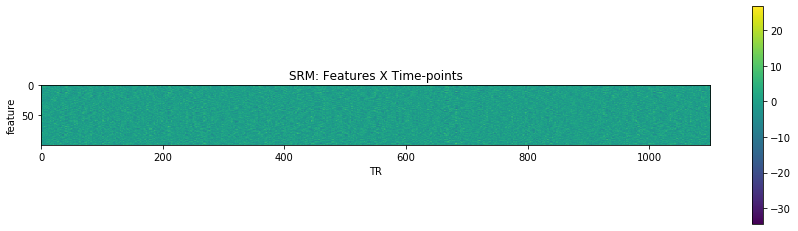

In [21]:
# Plot the shared response
print('SRM: Features X Time-points ', srm.s_.shape)
plt.figure(figsize=(15, 4))
plt.title('SRM: Features X Time-points')
plt.xlabel('TR')
plt.ylabel('feature')
plt.imshow(srm.s_, cmap='viridis')
plt.colorbar();

Let's zoom in and look at the first feature, i.e., the one that explains the most variance:

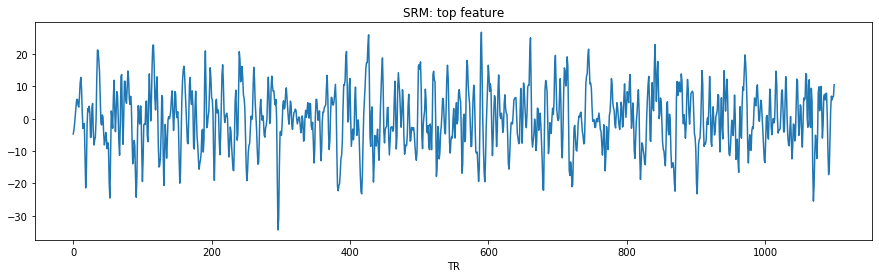

In [22]:
plt.figure(figsize=(15, 4))
plt.title('SRM: top feature')
plt.xlabel('TR')
plt.plot(srm.s_[0, :]);

By definition, this feature of brain activity is found consistently across participants. However, it is unclear where in the brain this feature is expressed. It is also unclear what stimulus information this feature represents. 

When there are spikes in the time course, such as around time point 300, something happened in the movie that is imporant to this feature. We could go back to the movie and examine what happened on screen at this time point, which would help better interpret the feature. For instance, we could go through the movie and code all of the times that Indiana Jones is in the scene and see if these spikes correspond to his presence. In reality, this feature is likely to code something much more abstract and complex than a specific person.

### 2.1 Similarity of timepoints <a id="srm_timepoints"></a>

We can now use this shared response to estimate how similar each timepoint is to one another. In other words, we treat each time point as a pattern of activity across the features and we correlate the pattern for each time point with the pattern for all other time points. This is analogous to the spatial ISC analysis from the ISC notebook. To do this, we calculate the distance between all time points in this $k$-dimensional space. Below, blue means that the time points are closer together or more similar. The yellow bands indicate time points where the patterns of activity diverge, potentially reflecting a unique time point in the movie.

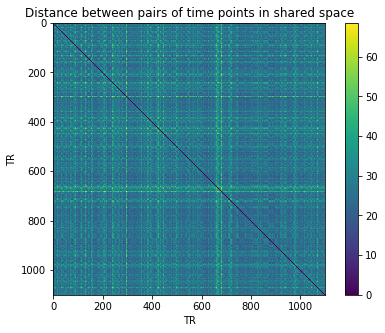

In [23]:
dist_mat = sp_distance.squareform(sp_distance.pdist(srm.s_.T))
plt.figure(figsize=(7,5))
plt.title('Distance between pairs of time points in shared space')
plt.xlabel('TR')
plt.ylabel('TR')
plt.imshow(dist_mat, cmap='viridis')
plt.colorbar()

### 2.2 The weight matrix <a id="srm_weights"></a>

In addition to the shared response matrix, we now also have an $n$ voxel by $k$ feature weight matrix for each participant that specifies how to map their data into the shared space. This is essentially a functional alignment transformation matrix. Below we visualize the weights associated with each feature for the same (anatomically-aligned) voxel in two different participants.

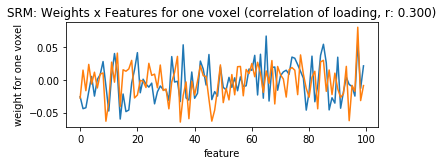

In [24]:
plt.subplot(211)

plt.plot(srm.w_[0][0,:])
plt.plot(srm.w_[1][0,:])
feature_corr = np.corrcoef(srm.w_[0][0,:], srm.w_[1][0,:].T)[0,1]
plt.title('SRM: Weights x Features for one voxel (correlation of loading, r: %0.3f)' % feature_corr) 
plt.xlabel('feature')
plt.ylabel('weight for one voxel')
plt.tight_layout()

Although there is some similarity, this shows that the same voxel loads on the features differently across participants. This means that anatomical alignment was not sufficient to align this function. Voxels that are more correlated with one another in terms of their raw time course are more likely to have similar loading into SRM space, regardless of anatomy.

### 2.3 ISC and SRM <a id="srm_alignment"></a>

We can also transform (i.e., functionally align) individual participant data into the shared space. This produces a $k$ feature by $t$ time matrix for each participant based on what components of their brain activity are shared with other participants. The `srm.transform` method is used for this purpose.

In [25]:
# Transform the SRM data into shared space
shared_train = srm.transform(train_data)

# Zscore the transformed training data
for subject in range(num_subs):
    shared_train[subject] = stats.zscore(shared_train[subject], axis=1, ddof=1)

Insofar as SRM worked, these projected feature time courses should be more similar across participants than the original voxel activity. We can test this with ISC: even though the shared features aren't in brain space, we can still use them as input to the ISC function.

In [26]:
# Reorganize the data back into an appropriate space for ISC. Use np.transpose to make it TRs x Voxels x subj
raw_obj = np.zeros((train_data[0].shape[0], train_data[0].shape[1], len(train_data)))
for ppt in range(len(train_data)):
    raw_obj[:, :, ppt] = train_data[ppt]
raw_obj=np.transpose(raw_obj,[1,0,2]) 

# Perform ISC on all participants, collapsing across participants    
corr_raw = isc(raw_obj, summary_statistic='mean')
corr_raw = np.nan_to_num(corr_raw)  

# Reorganize the SRM transformed data back into an appropriate space for ISC
shared_obj = np.zeros((shared_train[0].shape[0], shared_train[0].shape[1], len(train_data)))
for ppt in range(len(train_data)):
    shared_obj[:, :, ppt] = shared_train[ppt]
shared_obj=np.transpose(shared_obj,[1,0,2]) # TRs x Voxels x Subjects for ISC.

# Perform ISC on all participants, collapsing across participants        
corr_shared = isc(shared_obj, summary_statistic='mean')
corr_shared = np.nan_to_num(corr_shared)

Independent samples t test between raw and SRM transformed data: 57.44012622599021 p: 0.0


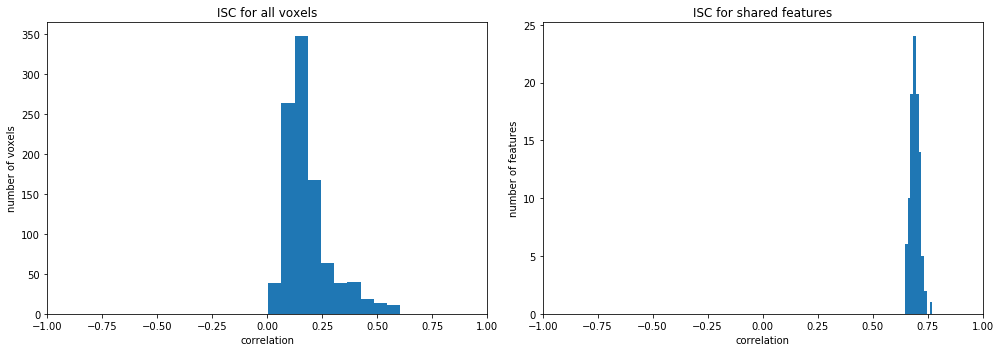

In [27]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.title('ISC for all voxels')
plt.hist(corr_raw);
plt.xlabel('correlation')
plt.ylabel('number of voxels')
plt.xlim([-1, 1]);

plt.subplot(1, 2, 2)
plt.title('ISC for shared features')
plt.hist(corr_shared);
plt.xlabel('correlation')
plt.ylabel('number of features')
plt.xlim([-1, 1]);

plt.tight_layout()

tstat = stats.ttest_ind(np.arctanh(corr_shared), np.arctanh(corr_raw))
print('Independent samples t test between raw and SRM transformed data:', tstat.statistic, 'p:', tstat.pvalue)

**Exercise 2:**<a id="ex2"></a> In the above analysis you found substantially greater similarity between participants after SRM. This worked well, suspiciously too well. What's wrong and how can you fix it?

**A**: make sure ISC is not being conducted between 2 of the same participants, make sure it's different data as in train + test 


## 3. SRM testing <a id="srm_testing"></a>

We held out some data that were never seen by SRM, which we can use to evaluate performance. If the same participants completed other tasks (e.g., face vs. scene), we could similarly use the model to functionally align those data prior to analysis (e.g., classification). 

In [28]:
# Transform the test data into the shared space using the individual weight matrices
shared_test = srm.transform(test_data)

# Zscore the transformed test data
for subject in range(num_subs):
    shared_test[subject] = stats.zscore(shared_test[subject], axis=1, ddof=1)

**Exercise 3:**<a id="ex3"></a> Repeat the ISC analysis above on the test data, comparing ISC in the original voxel space vs. the shared feature space. Interpret your findings.

In [29]:


# Reorganize the SRM transformed data back into an appropriate space for ISC
shared_obj = np.zeros((shared_test[0].shape[0], shared_test[0].shape[1], len(test_data)))
for ppt in range(len(test_data)):
    shared_obj[:, :, ppt] = shared_test[ppt]
shared_obj=np.transpose(shared_obj,[1,0,2]) # TRs x Voxels x Subjects for ISC.

# Perform ISC on all participants, collapsing across participants        
corr_shared = isc(shared_obj, summary_statistic='mean')
corr_shared = np.nan_to_num(corr_shared)




Independent samples t test between raw and SRM transformed data: 27.139129837341407 p: 1.5644869123090373e-124


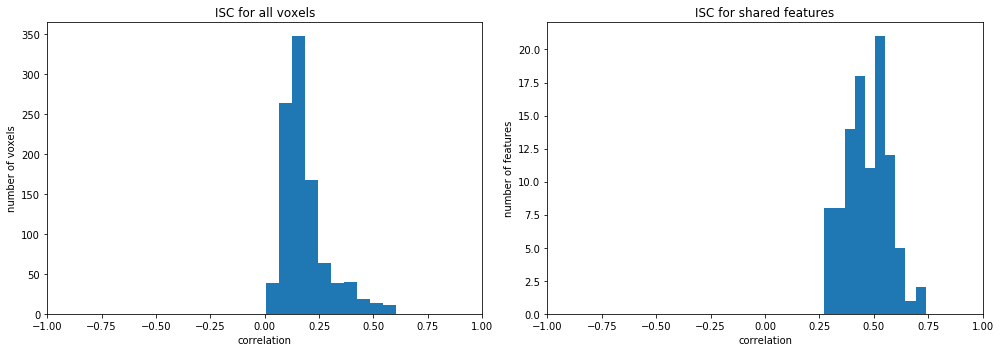

In [30]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.title('ISC for all voxels')
plt.hist(corr_raw);
plt.xlabel('correlation')
plt.ylabel('number of voxels')
plt.xlim([-1, 1]);

plt.subplot(1, 2, 2)
plt.title('ISC for shared features')
plt.hist(corr_shared);
plt.xlabel('correlation')
plt.ylabel('number of features')
plt.xlim([-1, 1]);

plt.tight_layout()

tstat = stats.ttest_ind(np.arctanh(corr_shared), np.arctanh(corr_raw))
print('Independent samples t test between raw and SRM transformed data:', tstat.statistic, 'p:', tstat.pvalue)

**A:** correlations are less strong but still exist once ISC is done 

**Exercise 4:** <a id="ex4"></a> In the analyses above we selected 50 features arbitrarily. This is an assumption about the dimensionality of the shared response. Try at least two values of $k$ and measure SRM performance in the test set, defined as the difference between raw and shared ISC. Report how performance of SRM changes with more features.

In [ ]:
# Insert code here

**A:**

## 4. Signal reconstruction  <a id="srm_reconstruction"></a>

The weight matrices that we created from SRM data are not only useful for projecting new data into a shared space but also for the reverse — reconstructing data in subject space. The logic of ISC that we covered in a previous notebook was that activity that is shared across participants when they are experiencing the same task is activity that reflects reliable task-evoked responses; comparison across individuals removes idiosyncratic responses. SRM can also exploit this logic: the participant-specific weights can be used to transform responses in shared space into brain activity in voxel space, isolating variance shared across participants and denoising the data.

In [ ]:
w0 = srm.w_[0]  # Weights for subject 1
signal_srm0 = w0.dot(shared_test[0])  # Reconstructed signal for subject 1

plt.figure(figsize=(10,5))
plt.title('SRM reconstructed vs. original signal for one voxel', fontsize=14)
plt.plot(signal_srm0[100,:100])
plt.plot(test_data[0][100,:100])
plt.xlabel('TR')
plt.ylabel('signal of one voxel')
plt.legend(('Reconstructed data', 'Original data'), loc=(1.04,0.5))
plt.tight_layout()

This data that has been transformed can also be used for ISC analyses like we did in section [2.3](#isc_srm). 

In [ ]:
# Do the reconstruction on all individual participants and organize it for ISC
signal_srm = np.zeros((test_data[0].shape[0], test_data[0].shape[1], len(test_data)))
for ppt in range(len(test_data)):
    w = srm.w_[ppt]
    signal_srm[:, :, ppt] = w.dot(shared_test[ppt])
signal_srm_for_isc=np.transpose(signal_srm,[1,0,2]) # TRs x Voxels x Subjects for ISC.
corr_reconstructed = isc(signal_srm_for_isc, summary_statistic='mean')
corr_reconstructed = np.nan_to_num(corr_reconstructed)

In [ ]:
# Plot the figure
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.title('ISC for all voxels')
plt.hist(corr_raw);
plt.xlabel('correlation')
plt.ylabel('number of voxels')
plt.xlim([-1, 1]);

plt.subplot(1, 2, 2)
plt.title('ISC for shared features')
plt.hist(corr_reconstructed);
plt.xlabel('correlation')
plt.ylabel('number of features')
plt.xlim([-1, 1]);

plt.tight_layout()

tstat = stats.ttest_1samp(np.arctanh(corr_reconstructed) - np.arctanh(corr_raw), 0)
print('Dependent samples t test between raw and SRM transformed data:', tstat.statistic, 'p:', tstat.pvalue)


Like we saw before, SRM is good at making participants similar participants to one another. In this case, `signal_srm` is a denoised version of the original data.

## 5. Time-segment matching<a id="time_seg"></a>
One of the tests that has been used to quantify the benefits of SRM is *time-segment matching*. This test involves taking an isolated, unknown segment of fMRI data from a held-out subject and trying to determine *when in the movie* the segment occurred, by comparing the segment to the whole fMRI time series acquired from other subjects. If you have a 30s "mystery" segment of data from a held-out subject, you could compare it to all 30s segments of group data from the whole movie and see which one has the highest neural similarity. For example, if the mystery segment matches best to the segment taken from 1:00 to 1:30 of the movie and that is actual time period during which the mystery segment of fMRI data was acquired, the match would be correct.  

The full process is shown in the figure below. The left part shows how to learn W and test on the held-out subject. Their data are transformed into the shared space by fixing $S$ and learning a mapping $W_m$ into this space. That is, the test subject does not impact the fitting of the shared responses but their data can still be projected into this space. The right part shows the algorithm used to determine the best-matching segment (here, a max-correlation classifier). Note that the classifier computes the match to the correct segment and all segments that do not overlap in time with the correct segment. Segments that overlap with the correct segment are excluded on the grounds that it would be difficult to distinguish segments that closely overlap in time.

![image](./imgs/lab11/srm_time_segment_matching.png)

The intuition behind time-segment matching is that, if the fMRI time series are well-aligned across participants and different parts of the movie have unique fMRI signatures, it should be possible to identify the mystery segment by comparing that segment to properly-timestamped fMRI time series from other participants. One might expect SRM to boost time-segment-matching accuracy, compared to anatomically aligned voxel space, by increasing the consistency of neural patterns across subjects.

The following sequence of steps is used to perform time-segment matching:

> - Create a sliding window of size `win_size`.
> - Break time series into `nseg` overlapping windows. 
> - Extract data for each of these segments.
> - One subject is taken out for leave-one-subject-out testing. Note the input data contain all subjects. The removal of one subject from a list for cross-validation is similar to what we covered in previous notebooks (e.g., FCMA).
> - A correlation is computed between the segments in the held-out subject and the segments from the average of the other subjects (similar ISC). The `compute_correlation` function in BrainIAK is used to calculate this.  
> - For each segment in the held-out subject, the segment from the average of others with the maximum correlation value is found.  
> - If the maximum correlation corresponds to the same time period in the test and training data, we score that as an accurate classification.  
> - The final accuracy of the classifier is returned for all subjects.  

In [ ]:
# Take in a list of participants of voxel by TR data. Also specify how big the time segment is to be matched
def time_segment_matching(data, win_size=10): 
    nsubjs = len(data)
    (ndim, nsample) = data[0].shape
    accu = np.zeros(shape=nsubjs)
    nseg = nsample - win_size 
    
    # mysseg prediction
    trn_data = np.zeros((ndim*win_size, nseg),order='f')
    
    # the training data also include the test data, but will be subtracted when calculating A
    for m in range(nsubjs):
        for w in range(win_size):
            trn_data[w*ndim:(w+1)*ndim,:] += data[m][:,w:(w+nseg)]
    for tst_subj in range(nsubjs):
        tst_data = np.zeros((ndim*win_size, nseg),order='f')
        for w in range(win_size):
            tst_data[w*ndim:(w+1)*ndim,:] = data[tst_subj][:,w:(w+nseg)]

        A =  np.nan_to_num(stats.zscore((trn_data - tst_data),axis=0, ddof=1))
        B =  np.nan_to_num(stats.zscore(tst_data,axis=0, ddof=1))

        # compute correlation matrix
        corr_mtx = compute_correlation(B.T,A.T)

        # The correlation classifier.
        for i in range(nseg):
            for j in range(nseg):
                # exclude segments overlapping with the testing segment
                if abs(i-j)<win_size and i != j :
                    corr_mtx[i,j] = -np.inf
        max_idx =  np.argmax(corr_mtx, axis=1)
        accu[tst_subj] = sum(max_idx == range(nseg)) / nseg

        # Print accuracy
        print("Accuracy for subj %d is: %0.4f" % (tst_subj, accu[tst_subj] ))
        
    print("The average accuracy among all subjects is {0:f} +/- {1:f}".format(np.mean(accu), np.std(accu)))
    return accu

First we are going to run time-segment matching on the training data in voxel space, without using any SRM.

In [ ]:
# Run for voxel data
accu_train_r = time_segment_matching(train_data, win_size=10)

The results show that trying to determine a time segment from raw data is quite difficult. Note that 13% is not bad because chance accuracy is less than 1% (1/number of segments = 1/1082 = 0.09%), but let's see if we can do better with SRM. 

**Exercise 5:**<a id="ex5"></a> Perform time-segment matching on both raw and SRM-transformed data for both training and test sets. Make a plot of the accuracies for the four conditions: raw training data, SRM-transformed training data, raw testing data, SRM-transformed testing data. Plot the average of each condition and error bars (standard error) across participants.

In [ ]:
# Insert code here

**Exercise 6:**<a id="ex6"></a> How does the number of subjects used to fit SRM impact performance? Fit SRMs on different numbers of subjects and perform time-segment matching to compare accuracy. Plot the accuracy for the test data when using 2 to 10 participants for training and testing the SRM. Plot average accuracy across subjects against the number of subjects used to fit SRM. 

In [ ]:
# Insert code here

**A:**

**Exercise 7:**<a id="ex7"></a> How does the number of time points used for training the SRM affect time-segment matching performance? Currently we are using half for training and half for testing but you can choose any proportion. Fill in the missing code to vary the proportion of time-points used for SRM training from 0.05, 0.1, 0.2, 0.4, and 0.6 and see how this changes time-segment matching accuracy for the held-out participant. 

In [ ]:
# Insert code here

# Preset some variables

accu = [] # Preset where you will store the average accuracy for each training set size
se = [] # Preset where you will store the standard error for each training set size

# Set up a loop to iterate through the different proportions of training data
prop_steps = [0.05, 0.1, 0.2, 0.4, 0.6]
for prop_split in prop_steps:

    # Figure out how many TRs there for this proportion
    num_split = int(nTR * prop_split)
    
    # Get the training and test data and Zscore both of them
    
    
    # Create the SRM object


    # Fit the SRM data


    # Transform the test data into the shared space using the individual weight matrices


    # Zscore the transformed test data


    # Run time segment matching
    
    
    # Append results of time segment matching to the list


## 6. Pieman analysis<a id="pieman"></a>

In the ISC notebook you used the Pieman dataset (see that notebook for more details). This dataset can also be used for SRM. It is much shorter in duration, with only 300 TRs per condition. However, we can still run a time-segment matching analysis.

Below we load the data from an A1 mask; participants are hearing an audio clip, so we expect auditory cortex to be driven by this stimulus. By using a small mask we can compensate for the relatively small number of data points in this dataset. We will also split the data into training (200 TRs) and test (100 TRs) sets.

<div class="alert alert-block alert-warning">
<strong>Memory limits</strong> Be aware this is going to be run on 18 participants and may push the limits of your memory resources if you are on a laptop. If you want to run it on fewer participants to protect memory, change `n_subjs` to be lower (e.g. 10); however, the anticipated results may not generalize to lower sample sizes.
</div>

In [ ]:
# How many participants do you want to load in
n_subjs = 18

# Set up experiment metadata
from utils import pieman2_dir

dir_mask = os.path.join(pieman2_dir, 'masks/')
mask_name = os.path.join(dir_mask, 'avg152T1_gray_3mm.nii.gz')
task_name = 'intact1'



def get_file_names(data_dir_, task_name_, verbose = False):
    """
    Parameters
    ----------
    data_dir_ [str]: the data root dir
    task_name_ [str]: the name of the task 
    
    Return
    ----------
    fnames_ [list]: file names for all subjs
    """
    c_ = 0 
    fnames_ = []
    # collect all file names 
    for subj in range(1, n_subjs + 1): 
        fname = os.path.join(
            data_dir_, 'sub-%.3d/func/sub-%.3d-task-%s.nii.gz' % (subj, subj, task_name_))
        # if the file exists
        if os.path.exists(fname):
            # add to the list of file names 
            fnames_.append(fname)
            if verbose: 
                print(fname)
            c_+= 1
    return fnames_

# Get all the participant names
fnames = get_file_names(pieman2_dir, task_name)

# Pull out an A1 mask
left_HG = nib.load(pieman2_dir + '/masks/rois/HG_L.nii.gz').get_data()
right_HG = nib.load(pieman2_dir + '/masks/rois/HG_R.nii.gz').get_data()
A1_mask = left_HG + right_HG

# Load in each participant data and then mask it with the A1 mask
pieman_train = []
pieman_test = []
for i in range(n_subjs):
    
    # Load and mask this participant's data
    data = nib.load(fnames[i]).get_data()
    masked_data = data[A1_mask == 1]
    
    pieman_train += [masked_data[:, :200]]
    pieman_test += [masked_data[:, 200:]]
    
    
print('Finished loading in Pieman data')

In [ ]:
masked_data.shape

**Exercise 8:**<a id="ex8"></a>  Perform time-segment matching on the Pieman dataset with raw voxel data and data transformed into SRM space, compare the results.

In [ ]:
# Insert answer here

**A:**

## 7. Image class prediction<a id="image_pred"></a>

We have demonstrated that functional alignment of participants (as measured by time-segment matching) can be improved when SRM is trained on movie data and then tested on movie data. This shows that the shared space learned on movie data transfers well to *other movie data*. An important question is whether this shared space is only useful for movie data, or whether it generalizes to other kinds of data. Put another way, should we think of the shared space obtained from movie data as being a general purpose shared space that can be used to align other kinds of experiences, or is it a specialized space that can only be used to align movies? 

Here, we will address this question by training SRM on movie data and then applying the trained model to a different experiment run in the same participants. In this experiment, participants were shown static images from seven different categories and seven-way classification of brain activity was performed (chance = 1/7). 

If SRM improves classification of image category across subjects, this would suggest that the shared space learned by SRM is applicable more broadly, at least to other visual experiments.

The classification procedure here is basically the same as other image-classification analyses from previous notebooks. The main difference is that we are leaving out one entire subject as the test set. That is, we are doing across-subject classification instead of within-subject classification.

In [ ]:
# Run a leave-one-out cross validation with the subjects
def image_class_prediction(image_data_shared, labels):
    
    subjects = len(image_data_shared)
    train_labels = np.tile(labels, subjects-1)
    test_labels = labels
    accuracy = np.zeros((subjects,))
    for subject in range(subjects):
        
        # Concatenate the subjects' data for training into one matrix
        train_subjects = list(range(subjects))
        train_subjects.remove(subject)
        TRs = image_data_shared[0].shape[1]
        train_data = np.zeros((image_data_shared[0].shape[0], len(train_labels)))
        for train_subject in range(len(train_subjects)):
            start_index = train_subject*TRs
            end_index = start_index+TRs
            train_data[:, start_index:end_index] = image_data_shared[train_subjects[train_subject]]

        # Train a Nu-SVM classifier using scikit learn
        classifier = NuSVC(nu=0.5, kernel='linear')
        classifier = classifier.fit(train_data.T, train_labels)

        # Predict on the test data
        predicted_labels = classifier.predict(image_data_shared[subject].T)
        accuracy[subject] = sum(predicted_labels == test_labels)/len(predicted_labels)
        # Print accuracy
        print("Accuracy for subj %d is: %0.4f" % (subject, accuracy[subject] ))
        
    print("The average accuracy among all subjects is {0:f} +/- {1:f}".format(np.mean(accuracy), np.std(accuracy)))
    return accuracy

**Exercise 9:**<a id="ex9"></a> Fill in the missing code below to fit an SRM with movie data (using 100 features) and then perform image classification on the transformed data.

In [ ]:
# Insert code here
# Load movie data as training
movie_data = np.load(os.path.join(raider_data_dir, 'movie.npy'))

# Load image data and labels as testing
image_data = np.load(os.path.join(raider_data_dir, 'image.npy'))
labels = np.load(os.path.join(raider_data_dir, 'label.npy'))

# convert to list
train_data = []
test_data = []
for sub in range(num_subs):
    train_data.append(movie_data[:,:,sub])  
    test_data.append(image_data[:,:,sub])  
del movie_data, image_data

# Zscore training and testing data

    
# Create the SRM object


# Fit the SRM data
   

# Transform the test data into the shared space using the individual weight matrices


# Zscore the transformed test data


# Run the classification analysis on the test data



**Exercise 10:**<a id="ex10"></a> Run the same classification analysis on the raw data (z-scored but not transformed by SRM) and compare the results to those above with SRM.  

In [ ]:
# Insert code here


**Novel contribution:** <a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.

**Some ideas for novel contribution:** 
- Use cross-validation to select the best number of SRM features for time-segment matching or image category classification.
- Try running SRM on the Pieman dataset without the mask or with different masks. What is different between Pieman and Raider datasets?

## Contributions <a id="contributions"></a>
M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 4/4/18  
C. Chen provided initial code  
H. Zhang major edits, added more exercises, added image class prediction section, filled in solutions, processed raider dataset, novel contribution ideas.  
M. Kumar edited sections and added details to the time-segment matching function.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis incorporated edits from cmhn-s19.  